# Analysing the $mBasicPH\_storage$ model

## Settings

For working with the model, we first import some packages and the modelclass:

In [1]:
# In case, working directory is not set correctly
#os.chdir('C:\\Users\\mpher\\Documents\\Uni\\Master\\02_Exchange\\01_Academics\\Energy Economics of the Green Transition\\0_Final Project\EnergyEconGroupWork')

In [2]:
import os
current_directory = os.getcwd()
print(current_directory)

c:\Users\mpher\Documents\Uni\Master\02_Exchange\01_Academics\Energy Economics of the Green Transition\EnergyEconGroupWork


In [3]:
%run ./stdPackages.ipynb
from pyDbs import *

os.chdir(os.path.join(d['curr'], 'py'))

from mBasicPH_storage import *
os.chdir(d['curr'])

Next we load the database:

In [4]:
kwargs = {'variables': ['Fundamentals', 'LoadVariables', 'GeneratorsVariables','StorageVariables','TransmissionLines'],
        'maps': ['LoadMaps','GeneratorsMaps','StorageMaps','MarketMaps'],
        'variable2D': ['HourlyVariation'],
        'scalars': ['Scalars']}

path_to_data = os.path.join(d['curr'], 'Data', 'mBasicPH_storage_Data.xlsx')

db = read.dbFromWB(path_to_data, kwargs)
readSets(db)

Convert variables to floats:

In [5]:
[db.__setitem__(var,db[var].astype(float).sort_index()) for var in db.getTypes('variable').keys()];

We need to read in heat areas manually:

In [6]:
db['g_H'] = db['id2g_H'].get_level_values('g_H').unique()

In [7]:
db['g_H']

Index(['DK_Central', 'DK_Decentral'], dtype='object', name='g_H')

We need to read in electricity areas manually:

In [8]:
db['g_E'] = db['id2g_E'].get_level_values('g_E').unique()

In [9]:
db['g_E']

Index(['DK'], dtype='object', name='g_E')

Collect all areas in one:

In [10]:
db['g'] = db['g_E'].copy()

## Initialze Baseline Model and Debug

In [11]:
m=mSimple(db)
m.db.symbols.keys()

dict_keys(['EmissionTax', 'EmissionIntensity', 'FuelPrice', 'Load_H', 'LoadVariation_H', 'Load_E', 'LoadVariation_E', 'GeneratingCap_E', 'FOM', 'FuelMix', 'GeneratingCap_H', 'OtherMC', 'E2H', 'chargeCap_H', 'sCap', 'effC', 'effD', 'selfDischarge', 'lineCapacity', 'lineFOM', 'lineMC', 'c_E2g_E', 'c_H2g_H', 'id2hvt', 'id2g_E', 'tech2modelTech', 'id2g_H', 'id2tech', 'g_E2g', 'g_E2g_H', 'g_H2g', 'CapVariation', 'MWP_E', 'MWP_H', 'lineLoss', 'EmissionType', 'BFt', 'c_H', 'h', 'c_E', 'id', 'g_E', 'g_E_alias', 'hvt', 'g_H', 'g', 'gConnected', 'id2modelTech2tech'])

The problem was, that the storage was not correctly mapped to the heating area. Now it is included in the index below. You can check so by searching for *id_DK_Central_HS* and *id_DK_Decentral_HS*.

In [12]:
m.db['id2g_H']

MultiIndex([(          'id_DK_Central_BH_Biogas',   'DK_Central'),
            (         'id_DK_Central_BH_Biomass',   'DK_Central'),
            (          'id_DK_Central_BH_Natgas',   'DK_Central'),
            (             'id_DK_Central_BH_Oil',   'DK_Central'),
            (           'id_DK_Central_BH_Waste',   'DK_Central'),
            (          'id_DK_Central_BP_Biogas',   'DK_Central'),
            (         'id_DK_Central_BP_Biomass',   'DK_Central'),
            (            'id_DK_Central_BP_Coal',   'DK_Central'),
            (          'id_DK_Central_BP_Natgas',   'DK_Central'),
            (             'id_DK_Central_BP_Oil',   'DK_Central'),
            (           'id_DK_Central_BP_Waste',   'DK_Central'),
            (                 'id_DK_Central_EP',   'DK_Central'),
            (         'id_DK_Central_HPstandard',   'DK_Central'),
            (      'id_DK_Central_HPsurplusheat',   'DK_Central'),
            (                 'id_DK_Central_HS',   'DK_Centra

## Solve Baseline Model

We then initialize and solve the model:

In [13]:
m()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


In [ ]:
m.db.symbols.keys()

Save solution for later:

In [21]:
base_db = m.db.copy()

In the following, we will aggregate the fuel types to the following types:

In [ ]:
#agg_BFt = {
#    'Fueloil':'Oil','Gasoil':'Oil', 
#    'Straw':'Biomass','WoodPellets':'Biomass','WoodChips':'Biomass','WoodWaste':'Biomass',
#    'Biogas':'Other Bio','BioOil':'Other Bio',
#    'Coal':'Coal',
#    'NatGas':'Natural gas',
#    'Waste':'Waste'
#}

### Inspect Baseline Solution

In [23]:
base_db['charge_H']

g_H           h     id                
DK_Central    1     id_DK_Central_HS      142.346000
              2     id_DK_Central_HS      142.346000
              3     id_DK_Central_HS      142.346000
              4     id_DK_Central_HS      142.346000
              5     id_DK_Central_HS        0.000000
                                             ...    
DK_Decentral  8756  id_DK_Decentral_HS    105.282967
              8757  id_DK_Decentral_HS    102.980473
              8758  id_DK_Decentral_HS    310.204976
              8759  id_DK_Decentral_HS    424.086000
              8760  id_DK_Decentral_HS    424.086000
Length: 17520, dtype: float64

In [25]:
base_db['discharge_H']

g_H           h     id                
DK_Central    1     id_DK_Central_HS        0.000000
              2     id_DK_Central_HS        0.000000
              3     id_DK_Central_HS        0.000000
              4     id_DK_Central_HS        0.000000
              5     id_DK_Central_HS      137.613349
                                             ...    
DK_Decentral  8756  id_DK_Decentral_HS      0.000000
              8757  id_DK_Decentral_HS      0.000000
              8758  id_DK_Decentral_HS      0.000000
              8759  id_DK_Decentral_HS      0.000000
              8760  id_DK_Decentral_HS      0.000000
Length: 17520, dtype: float64

In [26]:
base_db['stored_H']

g_H           h     id                
DK_Central    1     id_DK_Central_HS       569.805862
              2     id_DK_Central_HS       711.672413
              3     id_DK_Central_HS       853.419594
              4     id_DK_Central_HS       995.047505
              5     id_DK_Central_HS       856.596898
                                             ...     
DK_Decentral  8756  id_DK_Decentral_HS    7712.642245
              8757  id_DK_Decentral_HS    7809.133106
              8758  id_DK_Decentral_HS    8112.767280
              8759  id_DK_Decentral_HS    8530.026993
              8760  id_DK_Decentral_HS    8946.935613
Length: 17520, dtype: float64

Plotting **stored heat**:

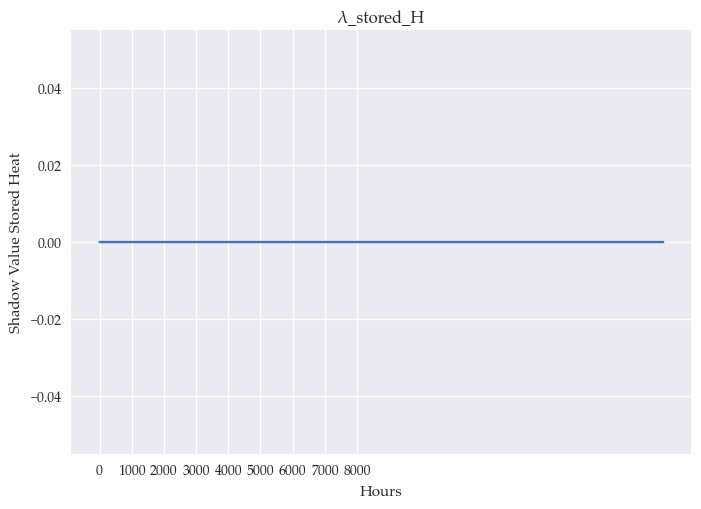

In [105]:
subset_stored_H = base_db['λ_stored_H'][base_db['λ_stored_H'].index.get_level_values('g_H') == 'DK_Central']

# For axis names
tick_positions = range(0, 8761, 1000)

# Plot the subset DataFrame
subset_stored_H.plot()
plt.xlabel('Hours')
plt.ylabel('Shadow Value Stored Heat')
plt.xticks(tick_positions, tick_positions)
plt.title('λ_stored_H')
plt.show()

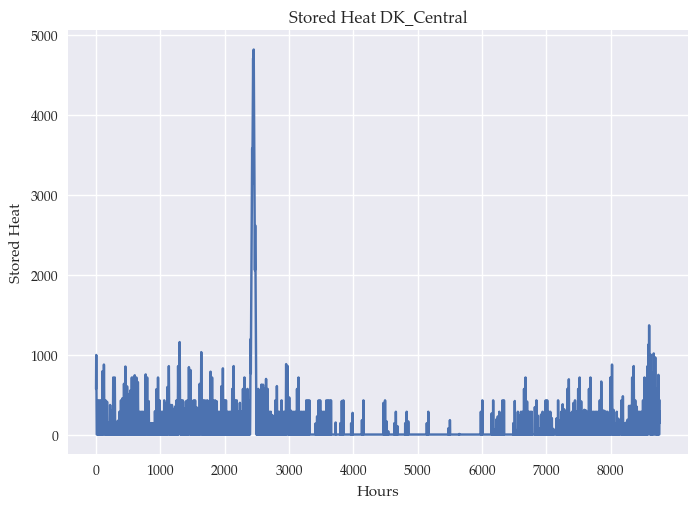

In [27]:
subset_stored_H = base_db['stored_H'][base_db['stored_H'].index.get_level_values('g_H') == 'DK_Central']

# For axis names
tick_positions = range(0, 8761, 1000)

# Plot the subset DataFrame
subset_stored_H.plot()
plt.xlabel('Hours')
plt.ylabel('Stored Heat')
plt.xticks(tick_positions, tick_positions)
plt.title('Stored Heat DK_Central')
plt.show()

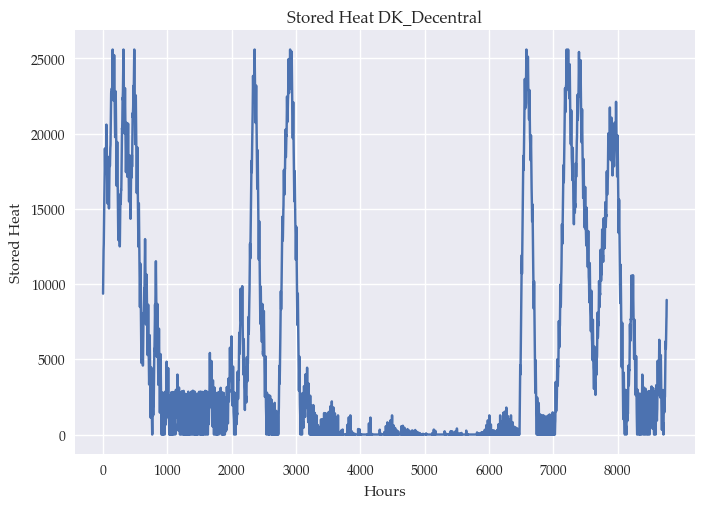

In [29]:
subset_stored_H = base_db['stored_H'][base_db['stored_H'].index.get_level_values('g_H') == 'DK_Decentral']

# For axis names
tick_positions = range(0, 8761, 1000)

# Plot the subset DataFrame
subset_stored_H.plot()
plt.xlabel('Hours')
plt.ylabel('Stored Heat')
plt.xticks(tick_positions, tick_positions)
plt.title('Stored Heat DK_Decentral')
plt.show()

Plotting **marginalSystemCosts_H**:

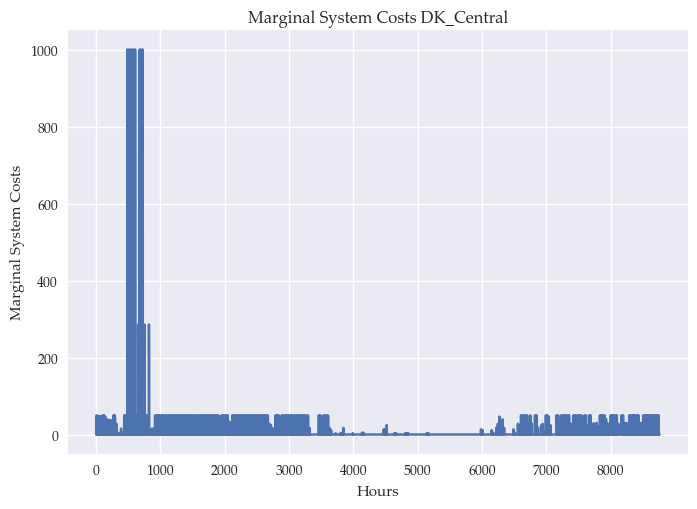

In [30]:
subset_stored_H = base_db['marginalSystemCosts_H'][base_db['marginalSystemCosts_H'].index.get_level_values('g_H') == 'DK_Central']

# For axis names
tick_positions = range(0, 8761, 1000)

# Plot the subset DataFrame
subset_stored_H.plot()
plt.xlabel('Hours')
plt.ylabel('Marginal System Costs')
plt.xticks(tick_positions, tick_positions)
plt.title('Marginal System Costs DK_Central')
plt.show()

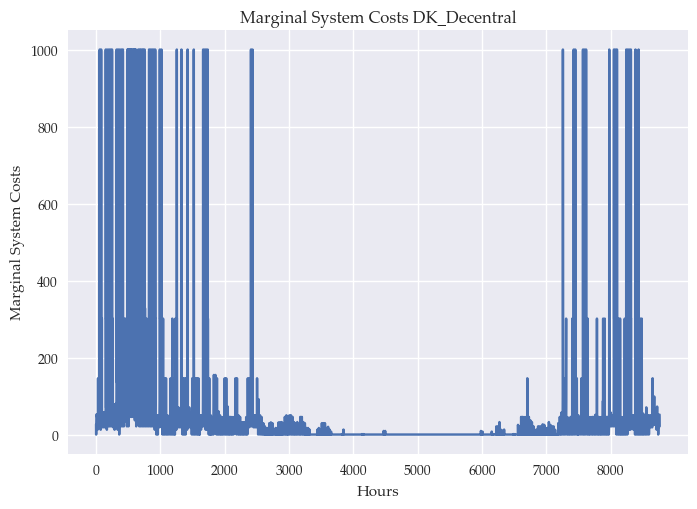

In [31]:
subset_stored_H = base_db['marginalSystemCosts_H'][base_db['marginalSystemCosts_H'].index.get_level_values('g_H') == 'DK_Decentral']

# For axis names
tick_positions = range(0, 8761, 1000)

# Plot the subset DataFrame
subset_stored_H.plot()
plt.xlabel('Hours')
plt.ylabel('Marginal System Costs')
plt.xticks(tick_positions, tick_positions)
plt.title('Marginal System Costs DK_Decentral')
plt.show()

## Increase Storage Capacity

These are the baseline storage capacities:

In [33]:
base_db['sCap']

id
id_DK_Central_HS       8589.844828
id_DK_Decentral_HS    25591.396552
Name: sCap, dtype: float64

In the following, we will run an experiment where we are exogenously increase the capacity of the storage technology from the baseline levels. We will assume the same storage duration of **60.344828 hours** as in the baseline scenario.

We will also be extracting the following variables:

In [106]:
extract = ['marginalSystemCosts_E','marginalSystemCosts_H','stored_H','Welfare','Emissions', 'marginalEconomicValue', 'meanConsumerPrice_E', 'meanConsumerPrice_H']

### Central_HS

In [152]:
# Setting
E2H = 60.344828 # The "energy storage to heat"-ratio/storage duration
maxcap_C = base_db['sCap'].values[0]*2
loop_C = pd.RangeIndex(start=int(base_db['sCap'].values[0]), stop=int(maxcap_C), step=5000, name = 'loop')
v0_GCap_C = base_db['GeneratingCap_H']['id_DK_Central_HS']
vT_GCap_C = maxcap_C
v0_SCap_C = v0_GCap_C*E2H
vT_SCap_C = vT_GCap_C*E2H

grid_GCap_C = adjMultiIndex.addGrid(v0_GCap_C,vT_GCap_C,loop_C,'GeneratingCapacity_Central_HS').astype(int)
grid_SCap_C = adjMultiIndex.addGrid(v0_SCap_C,vT_SCap_C,loop_C,'sCap_Central_HS').astype(int)

In [153]:
grid_SCap_C

loop
8589        8589
13589    1036705
Name: sCap_Central_HS, dtype: int32

We now run the counterfactual scenarios:

In [154]:
solution_C = m.loopSolveExtract(loop_C, [grid_GCap_C, grid_SCap_C], extract)

In [156]:
solution_C['stored_H']['DK_Central']

h     id                loop 
1     id_DK_Central_HS  8589     713.476047
                        13589    713.476047
2     id_DK_Central_HS  8589     855.221710
                        13589    855.221710
3     id_DK_Central_HS  8589     996.848105
                                    ...    
8758  id_DK_Central_HS  13589    293.786061
8759  id_DK_Central_HS  8589     429.626514
                        13589    429.626514
8760  id_DK_Central_HS  8589     571.611015
                        13589    571.611015
Length: 17520, dtype: float64

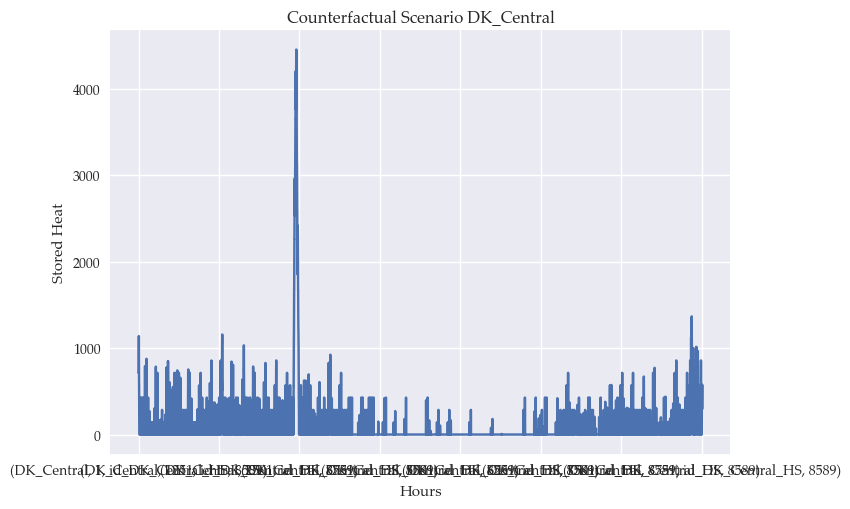

In [162]:
subset_solution_C_stored_H = solution_C['stored_H'][solution_C['stored_H'].index.get_level_values('g_H') == 'DK_Central']

# For axis names
tick_positions = range(0, 8761, 1000)

# Plot the subset DataFrame
subset_solution_C_stored_H.plot()
plt.xlabel('Hours')
plt.ylabel('Stored Heat')
#plt.xticks(tick_positions, tick_positions)
plt.title('Counterfactual Scenario DK_Central')
plt.show()

### Decentral_HS

In [157]:
# Setting

maxcap_DC = base_db['sCap'].values[1]*2
loop_DC = pd.RangeIndex(start=int(base_db['sCap'].values[1]), stop=int(maxcap_DC), step=15000, name = 'loop')
v0_GCap_DC = base_db['GeneratingCap_H']['id_DK_Decentral_HS']
vT_GCap_DC = maxcap_DC
v0_SCap_DC = v0_GCap_DC*E2H
vT_SCap_DC = vT_GCap_DC*E2H

grid_GCap_DC = adjMultiIndex.addGrid(v0_GCap_DC,vT_GCap_DC,loop_DC,'GeneratingCapacity_Decentral_HS').astype(int)
grid_SCap_DC = adjMultiIndex.addGrid(v0_SCap_DC,vT_SCap_DC,loop_DC,'sCap_Decentral_HS').astype(int)

In [151]:
grid_SCap_DC

loop
25591      25591
40591    3088616
Name: sCap_Decentral_HS, dtype: int32

In [158]:
solution_DC = m.loopSolveExtract(loop_DC, [grid_GCap_DC, grid_SCap_DC], extract)

In [160]:
solution_DC['stored_H']['DK_Decentral']

h     id                  loop 
1     id_DK_Decentral_HS  25591    1328.461618
                          40591    1328.461618
2     id_DK_Decentral_HS  25591    1751.429817
                          40591    1751.429817
3     id_DK_Decentral_HS  25591    2174.042119
                                      ...     
8758  id_DK_Decentral_HS  40591     183.345115
8759  id_DK_Decentral_HS  25591     481.456333
                          40591     481.456333
8760  id_DK_Decentral_HS  25591     905.137223
                          40591     905.137223
Length: 17520, dtype: float64

What to plot?

- CO2 Emissions
- Usage of Storage
- Marginal Economic value of storage
- seasonal storage?